In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import pygsheets
from google.oauth2.service_account import Credentials
from oauth2client.service_account import ServiceAccountCredentials
from tqdm import tqdm
from time import time



# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType


import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2
import pandas_gbq

In [2]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [3]:
credentials = Credentials.from_service_account_file('C:/Users/leemn/Documents/Service Account/bright-arc-328707-173b23869758.json')

In [4]:
data = pd.read_excel(r"C:/Users/leemn/Documents/Work/Work/down/assessments/Airlift/Data_Airlift_Q1.xlsx")
data.head()

,warehouse,Date,total_orders
0,EW1,2021-08-10,455
1,EW1,2021-08-11,553
2,EW1,2021-08-12,569
3,EW1,2021-08-13,426
4,EW1,2021-08-14,536


In [5]:
print("The data has sales from {} to {}".format(min(data['Date']),
                                                 max(data['Date'])))

The data has sales from 2021-08-10 00:00:00 to 2021-11-08 00:00:00


In [6]:
data.shape

(145, 3)

In [7]:
data.isnull().sum()/len(data)*100

warehouse       0.0
Date            0.0
total_orders    0.0
dtype: float64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   warehouse     145 non-null    object        
 1   Date          145 non-null    datetime64[ns]
 2   total_orders  145 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ KB


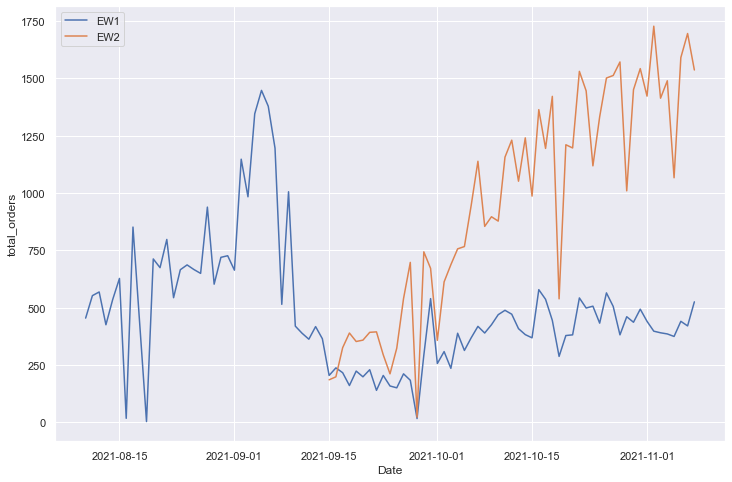

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['Date'], y=data['total_orders'],hue=data['warehouse'])
plt.legend()
plt.show()

In [10]:
# Change data from the wide format to the long format
data.columns = [ 'warehouse','ds', 'y']
df = data[['ds','warehouse','y']]
df.head()

,ds,warehouse,y
0,2021-08-10,EW1,455
1,2021-08-11,EW1,553
2,2021-08-12,EW1,569
3,2021-08-13,EW1,426
4,2021-08-14,EW1,536


## Train Prophet model

In [11]:
# Group the data by ticker
groups_by_ticker = df.groupby('warehouse')
# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['EW1', 'EW2'])

In [12]:
def train_and_forecast(group):
    m = Prophet(interval_width = 0.95)
    m.fit(group)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['warehouse'] = group['warehouse'].iloc[0]
  
    return forecast[['ds', 'warehouse', 'yhat', 'yhat_upper', 'yhat_lower']]

In [13]:
start_time = time()

warehouse_list = ['EW1', 'EW2']

for_loop_forecast = pd.DataFrame()

# Loop through each warehouse
for whs in warehouse_list:
    group = groups_by_ticker.get_group(whs)  
    forecast = train_and_forecast(group)
    for_loop_forecast = pd.concat((for_loop_forecast, forecast))
print('The time used for the for-loop forecast is ', time()-start_time)

21:13:04 - cmdstanpy - INFO - Chain [1] start processing
21:13:04 - cmdstanpy - INFO - Chain [1] done processing
21:13:06 - cmdstanpy - INFO - Chain [1] start processing
21:13:06 - cmdstanpy - INFO - Chain [1] done processing


The time used for the for-loop forecast is  3.5259242057800293


## Evaluate model

In [14]:
df_merge = pd.merge(df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-09-15,-72.345689,625.892159,270.258590,205
1,2021-09-15,-72.345689,625.892159,270.258590,186
2,2021-09-16,-43.219681,695.099817,313.237011,238
3,2021-09-16,-43.219681,695.099817,313.237011,199
4,2021-09-17,-234.511785,504.732521,131.133179,217


In [21]:
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)

MAE: 370.953


In [22]:
# The mean absolute percent error (MAPE) expresses accuracy as a percentage of the error.
# MAPE is 1.3, menaing on average, the forecast is off by 1.3%
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAPE: 1.334


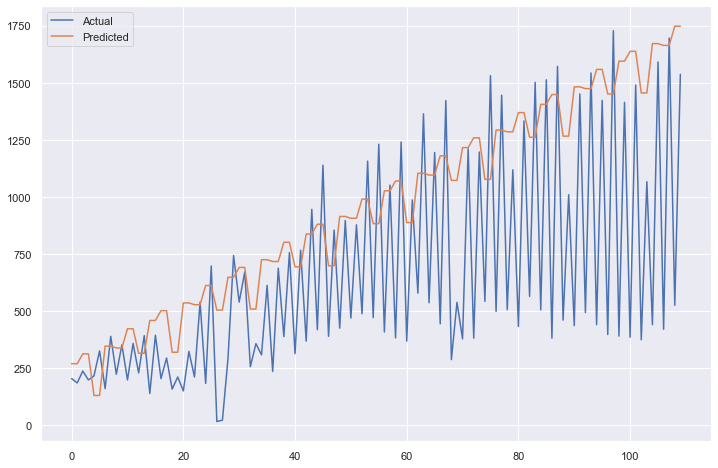

In [23]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [15]:
# Push predictions to BigQuery
df_merge.to_gbq(destination_table='bright-arc-328707.test.warehouse_order_predictions',
               project_id='bright-arc-328707',
               credentials=credentials,
               chunksize=100000,
               progress_bar=True,
               if_exists='replace')

110 out of 110 rows loaded.<?, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 991.56it/s]
